In [774]:
conda create --name spam --channel cantera cantera ipython matplotlib

^C

Note: you may need to restart the kernel to use updated packages.


In [228]:
import cantera as ct
import numpy as np

#############################################################
#################### PARA HIDROGENO Y METANO ##########################
##############################################################

f = 2500. / 60.  # engine speed [1/s] (3000 rpm)
V_H = .03995e-3   # displaced voTlume [m**3]
epsilon = 9.6  # compression ratio [-]
d_piston = 0.083  # piston diameter [m]

# turbocharger temperature, pressure, and composition
T_inlet = 300.  # K
p_inlet = 1.3e5  # Pa
comp_inlet = 'O2:1, N2:3.76'

# outlet pressure
p_outlet = 1.2e5  # Pa

# fuel properties (gaseous!)
T_injector = 283  # K
#p_injector = 1600e5  # Pa
p_injector = 1e6 
comp_injector = 'CH4:1'
comp_injector1 = 'CH4:0.5, H2:0.5'
comp_injector2 = 'CH4:0.7, H2:0.3'
comp_injector3 = 'CH4:0.95, H2:0.05'


# ambient properties
T_ambient = 300.  # K
p_ambient = 1e5  # Pa
comp_ambient = 'O2:1, N2:3.76'

# Reaction mechanism name
reaction_mechanism = 'gri30.xml'

# Inlet valve friction coefficient, open and close timings
inlet_valve_coeff = 1.e-6
inlet_open = -18. / 180. * np.pi
inlet_close = 198. / 180. * np.pi

# Outlet valve friction coefficient, open and close timings
outlet_valve_coeff = 1.e-6
outlet_open = 522. / 180 * np.pi
outlet_close = 18. / 180. * np.pi

# Fuel mass, injector open and close timings
injector_open = 350. / 180. * np.pi
injector_close = 365. / 180. * np.pi
#injector_mass = 3.2e-5  # kg
injector_mass = 3.2e-5  # kg
injector_t_open = (injector_close - injector_open) / 2. / np.pi / f

# Simulation time and resolution
sim_n_revolutions = 8.
sim_n_timesteps = 100000.

In [229]:
#############################################################
#################### PARA FULL CH4 ##########################
##############################################################

# load reaction mechanism
gas = ct.Solution(reaction_mechanism)

# define initial state
gas.TPX = T_inlet, p_inlet, comp_inlet
r = ct.IdealGasReactor(gas)
# define inlet state
gas.TPX = T_inlet, p_inlet, comp_inlet
inlet = ct.Reservoir(gas)
# define injector state (gaseous!)
gas.TPX = T_injector, p_injector, comp_injector
injector = ct.Reservoir(gas)
# define outlet pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_outlet, comp_ambient
outlet = ct.Reservoir(gas)
# define ambient pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_ambient, comp_ambient
ambient_air = ct.Reservoir(gas)

# set up connecting devices
inlet_valve = ct.Valve(inlet, r)
injector_mfc = ct.MassFlowController(injector, r)
outlet_valve = ct.Valve(r, outlet)
piston = ct.Wall(ambient_air, r)

# convert time to crank angle
def crank_angle(t):
    return np.remainder(2 * np.pi * f * t, 4 * np.pi)

# set up IC engine parameters
V_oT = V_H / (epsilon - 1.)
A_piston = .25 * np.pi * d_piston ** 2
stroke = V_H / A_piston
#stroke = 0.0815
r.volume = V_oT
piston.area = A_piston
def piston_speed(t):
    return - stroke / 2 * 2 * np.pi * f * np.sin(crank_angle(t))
piston.set_velocity(piston_speed)

# create a reactor network containing the cylinder
sim = ct.ReactorNet([r])

# set up output data arrays
states = ct.SolutionArray(r.thermo)
t_sim = sim_n_revolutions / f
t = (np.arange(sim_n_timesteps) + 1) / sim_n_timesteps * t_sim
V = np.zeros_like(t)
m = np.zeros_like(t)
test = np.zeros_like(t)
mdot_in = np.zeros_like(t)
mdot_out = np.zeros_like(t)
d_W_v_d_t = np.zeros_like(t)
heat_release_rate = np.zeros_like(t)

# set parameters for the automatic time step refinement
n_last_refinement = -np.inf  # for initialization only
n_wait_coarsening = 10

# do simulation
for n1, t_i in enumerate(t):
    # define opening and closing of valves and injector
    if (np.mod(crank_angle(t_i) - inlet_open, 4 * np.pi) <
            np.mod(inlet_close - inlet_open, 4 * np.pi)):
        inlet_valve.set_valve_coeff(inlet_valve_coeff)
        test[n1] = 1
    else:
        inlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - outlet_open, 4 * np.pi) <
            np.mod(outlet_close - outlet_open, 4 * np.pi)):
        outlet_valve.set_valve_coeff(outlet_valve_coeff)
    else:
        outlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - injector_open, 4 * np.pi) <
            np.mod(injector_close - injector_open, 4 * np.pi)):
        injector_mfc.set_mass_flow_rate(injector_mass / injector_t_open)
    else:
        injector_mfc.set_mass_flow_rate(0)

    # perform time integration, refine time step if necessary
    for n2 in range(4):
        if n2 is 4:
            raise 'Error: Refinement limit reached'
        try:
            sim.advance(t_i)
        except Exception:
            sim.set_max_time_step(1e-6 * 10. ** -n2)
            n_last_refinement = n1
    # coarsen time step if too long ago
    if n1 - n_last_refinement is n_wait_coarsening:
        sim.set_max_time_step(1e-5)

    # write output data
    states.append(r.thermo.state)
    V[n1] = r.volume
    m[n1] = r.mass
    mdot_in[n1] = inlet_valve.mdot(0)
    mdot_out[n1] = outlet_valve.mdot(0)
    d_W_v_d_t[n1] = - (r.thermo.P - ambient_air.thermo.P) * A_piston *         piston_speed(t_i)
    heat_release_rate[n1] = - r.volume * ct.gas_constant * r.T *         np.sum(gas.standard_enthalpies_RT * r.thermo.net_production_rates, 0)


<>:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-229-c36bf6b6f4c3>:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if n2 is 4:
<ipython-input-229-c36bf6b6f4c3>:69: DeprecationWarning: To be removed after Cantera 2.5. Use property 'valve_coeff' and/or function 'set_pressure_function' instead.
  inlet_valve.set_valve_coeff(inlet_valve_coeff)
<ipython-input-229-c36bf6b6f4c3>:75: DeprecationWarning: To be removed after Cantera 2.5. Use property 'valve_coeff' and/or function 'set_pressure_function' instead.
  outlet_valve.set_valve_coeff(outlet_valve_coeff)
<ipython-input-229-c36bf6b6f4c3>:82: DeprecationWarning: To be removed after Cantera 2.5. Replaced by property 'mass_flow_rate'
  injector_mfc.set_mass_flow_rate(0)
<ipython-input-229-c36bf6b6f4c3>:101: DeprecationWarning: To be removed after Cantera 2.5. Replaced by property 'mass_flow_rate'
  mdot_in[n1] = inlet_valve.mdot(0)
<ipython

In [230]:
#############################################################
#################### PARA  CH4 50% Y H2 50% ##################
##############################################################


# load reaction mechanism
gas = ct.Solution(reaction_mechanism)

# define initial state
gas.TPX = T_inlet, p_inlet, comp_inlet
r = ct.IdealGasReactor(gas)
# define inlet state
gas.TPX = T_inlet, p_inlet, comp_inlet
inlet = ct.Reservoir(gas)
# define injector state (gaseous!)
gas.TPX = T_injector, p_injector, comp_injector1
injector = ct.Reservoir(gas)
# define outlet pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_outlet, comp_ambient
outlet = ct.Reservoir(gas)
# define ambient pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_ambient, comp_ambient
ambient_air = ct.Reservoir(gas)

# set up connecting devices
inlet_valve = ct.Valve(inlet, r)
injector_mfc = ct.MassFlowController(injector, r)
outlet_valve = ct.Valve(r, outlet)
piston = ct.Wall(ambient_air, r)

# convert time to crank angle
def crank_angle(t):
    return np.remainder(2 * np.pi * f * t, 4 * np.pi)

# set up IC engine parameters
V_oT = V_H / (epsilon - 1.)
A_piston = .25* np.pi * d_piston ** 2
stroke = V_H / A_piston
#stroke = 0.0815
r.volume = V_oT
piston.area = A_piston
def piston_speed(t):
    return - stroke / 2 * 2 * np.pi * f * np.sin(crank_angle(t))
piston.set_velocity(piston_speed)

# create a reactor network containing the cylinder
sim = ct.ReactorNet([r])

# set up output data arrays
states1 = ct.SolutionArray(r.thermo)
t_sim = sim_n_revolutions / f
t = (np.arange(sim_n_timesteps) + 1) / sim_n_timesteps * t_sim
V1 = np.zeros_like(t)
m = np.zeros_like(t)
test = np.zeros_like(t)
mdot_in = np.zeros_like(t)
mdot_out = np.zeros_like(t)
d_W_v_d_t = np.zeros_like(t)
heat_release_rate = np.zeros_like(t)

# set parameters for the automatic time step refinement
n_last_refinement = -np.inf  # for initialization only
n_wait_coarsening = 10

# do simulation
for n1, t_i in enumerate(t):
    # define opening and closing of valves and injector
    if (np.mod(crank_angle(t_i) - inlet_open, 4 * np.pi) <
            np.mod(inlet_close - inlet_open, 4 * np.pi)):
        inlet_valve.set_valve_coeff(inlet_valve_coeff)
        test[n1] = 1
    else:
        inlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - outlet_open, 4 * np.pi) <
            np.mod(outlet_close - outlet_open, 4 * np.pi)):
        outlet_valve.set_valve_coeff(outlet_valve_coeff)
    else:
        outlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - injector_open, 4 * np.pi) <
            np.mod(injector_close - injector_open, 4 * np.pi)):
        injector_mfc.set_mass_flow_rate(injector_mass / injector_t_open)
    else:
        injector_mfc.set_mass_flow_rate(0)

    # perform time integration, refine time step if necessary
    for n2 in range(4):
        if n2 is 4:
            raise 'Error: Refinement limit reached'
        try:
            sim.advance(t_i)
        except Exception:
            sim.set_max_time_step(1e-6 * 10. ** -n2)
            n_last_refinement = n1
    # coarsen time step if too long ago
    if n1 - n_last_refinement is n_wait_coarsening:
        sim.set_max_time_step(1e-5)

    # write output data
    states1.append(r.thermo.state)
    V1[n1] = r.volume
    m[n1] = r.mass
    mdot_in[n1] = inlet_valve.mdot(0)
    mdot_out[n1] = outlet_valve.mdot(0)
    d_W_v_d_t[n1] = - (r.thermo.P - ambient_air.thermo.P) * A_piston *         piston_speed(t_i)
    heat_release_rate[n1] = - r.volume * ct.gas_constant * r.T *         np.sum(gas.standard_enthalpies_RT * r.thermo.net_production_rates, 0)

<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-230-45aaa5209535>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if n2 is 4:
<ipython-input-230-45aaa5209535>:70: DeprecationWarning: To be removed after Cantera 2.5. Use property 'valve_coeff' and/or function 'set_pressure_function' instead.
  inlet_valve.set_valve_coeff(inlet_valve_coeff)
<ipython-input-230-45aaa5209535>:76: DeprecationWarning: To be removed after Cantera 2.5. Use property 'valve_coeff' and/or function 'set_pressure_function' instead.
  outlet_valve.set_valve_coeff(outlet_valve_coeff)
<ipython-input-230-45aaa5209535>:83: DeprecationWarning: To be removed after Cantera 2.5. Replaced by property 'mass_flow_rate'
  injector_mfc.set_mass_flow_rate(0)
<ipython-input-230-45aaa5209535>:102: DeprecationWarning: To be removed after Cantera 2.5. Replaced by property 'mass_flow_rate'
  mdot_in[n1] = inlet_valve.mdot(0)
<ipython

In [231]:
#############################################################
#################### PARA  CH4 70% Y H2 30% ##################
##############################################################


# load reaction mechanism
gas = ct.Solution(reaction_mechanism)

# define initial state
gas.TPX = T_inlet, p_inlet, comp_inlet
r = ct.IdealGasReactor(gas)
# define inlet state
gas.TPX = T_inlet, p_inlet, comp_inlet
inlet = ct.Reservoir(gas)
# define injector state (gaseous!)
gas.TPX = T_injector, p_injector, comp_injector2
injector = ct.Reservoir(gas)
# define outlet pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_outlet, comp_ambient
outlet = ct.Reservoir(gas)
# define ambient pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_ambient, comp_ambient
ambient_air = ct.Reservoir(gas)

# set up connecting devices
inlet_valve = ct.Valve(inlet, r)
injector_mfc = ct.MassFlowController(injector, r)
outlet_valve = ct.Valve(r, outlet)
piston = ct.Wall(ambient_air, r)

# convert time to crank angle
def crank_angle(t):
    return np.remainder(2 * np.pi * f * t, 4 * np.pi)

# set up IC engine parameters
V_oT = V_H / (epsilon - 1.)
A_piston = .25* np.pi * d_piston ** 2
stroke = V_H / A_piston
#stroke = 0.0815
r.volume = V_oT
piston.area = A_piston
def piston_speed(t):
    return - stroke / 2 * 2 * np.pi * f * np.sin(crank_angle(t))
piston.set_velocity(piston_speed)

# create a reactor network containing the cylinder
sim = ct.ReactorNet([r])

# set up output data arrays
states2 = ct.SolutionArray(r.thermo)
t_sim = sim_n_revolutions / f
t = (np.arange(sim_n_timesteps) + 1) / sim_n_timesteps * t_sim
V2 = np.zeros_like(t)
m = np.zeros_like(t)
test = np.zeros_like(t)
mdot_in = np.zeros_like(t)
mdot_out = np.zeros_like(t)
d_W_v_d_t = np.zeros_like(t)
heat_release_rate = np.zeros_like(t)

# set parameters for the automatic time step refinement
n_last_refinement = -np.inf  # for initialization only
n_wait_coarsening = 10

# do simulation
for n1, t_i in enumerate(t):
    # define opening and closing of valves and injector
    if (np.mod(crank_angle(t_i) - inlet_open, 4 * np.pi) <
            np.mod(inlet_close - inlet_open, 4 * np.pi)):
        inlet_valve.set_valve_coeff(inlet_valve_coeff)
        test[n1] = 1
    else:
        inlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - outlet_open, 4 * np.pi) <
            np.mod(outlet_close - outlet_open, 4 * np.pi)):
        outlet_valve.set_valve_coeff(outlet_valve_coeff)
    else:
        outlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - injector_open, 4 * np.pi) <
            np.mod(injector_close - injector_open, 4 * np.pi)):
        injector_mfc.set_mass_flow_rate(injector_mass / injector_t_open)
    else:
        injector_mfc.set_mass_flow_rate(0)

    # perform time integration, refine time step if necessary
    for n2 in range(4):
        if n2 is 4:
            raise 'Error: Refinement limit reached'
        try:
            sim.advance(t_i)
        except Exception:
            sim.set_max_time_step(1e-6 * 10. ** -n2)
            n_last_refinement = n1
    # coarsen time step if too long ago
    if n1 - n_last_refinement is n_wait_coarsening:
        sim.set_max_time_step(1e-5)

    # write output data
    states2.append(r.thermo.state)
    V2[n1] = r.volume
    m[n1] = r.mass
    mdot_in[n1] = inlet_valve.mdot(0)
    mdot_out[n1] = outlet_valve.mdot(0)
    d_W_v_d_t[n1] = - (r.thermo.P - ambient_air.thermo.P) * A_piston *         piston_speed(t_i)
    heat_release_rate[n1] = - r.volume * ct.gas_constant * r.T *         np.sum(gas.standard_enthalpies_RT * r.thermo.net_production_rates, 0)

<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-231-173f1d8b98e0>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if n2 is 4:
<ipython-input-231-173f1d8b98e0>:70: DeprecationWarning: To be removed after Cantera 2.5. Use property 'valve_coeff' and/or function 'set_pressure_function' instead.
  inlet_valve.set_valve_coeff(inlet_valve_coeff)
<ipython-input-231-173f1d8b98e0>:76: DeprecationWarning: To be removed after Cantera 2.5. Use property 'valve_coeff' and/or function 'set_pressure_function' instead.
  outlet_valve.set_valve_coeff(outlet_valve_coeff)
<ipython-input-231-173f1d8b98e0>:83: DeprecationWarning: To be removed after Cantera 2.5. Replaced by property 'mass_flow_rate'
  injector_mfc.set_mass_flow_rate(0)
<ipython-input-231-173f1d8b98e0>:102: DeprecationWarning: To be removed after Cantera 2.5. Replaced by property 'mass_flow_rate'
  mdot_in[n1] = inlet_valve.mdot(0)
<ipython

In [232]:
#############################################################
#################### PARA  CH4 95% Y H2 5% ##################
##############################################################


# load reaction mechanism
gas = ct.Solution(reaction_mechanism)

# define initial state
gas.TPX = T_inlet, p_inlet, comp_inlet
r = ct.IdealGasReactor(gas)
# define inlet state
gas.TPX = T_inlet, p_inlet, comp_inlet
inlet = ct.Reservoir(gas)
# define injector state (gaseous!)
gas.TPX = T_injector, p_injector, comp_injector3
injector = ct.Reservoir(gas)
# define outlet pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_outlet, comp_ambient
outlet = ct.Reservoir(gas)
# define ambient pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_ambient, comp_ambient
ambient_air = ct.Reservoir(gas)

# set up connecting devices
inlet_valve = ct.Valve(inlet, r)
injector_mfc = ct.MassFlowController(injector, r)
outlet_valve = ct.Valve(r, outlet)
piston = ct.Wall(ambient_air, r)

# convert time to crank angle
def crank_angle(t):
    return np.remainder(2 * np.pi * f * t, 4 * np.pi)

# set up IC engine parameters
V_oT = V_H / (epsilon - 1.)
A_piston = .25* np.pi * d_piston ** 2
stroke = V_H / A_piston
#stroke = 0.0815
r.volume = V_oT
piston.area = A_piston
def piston_speed(t):
    return - stroke / 2 * 2 * np.pi * f * np.sin(crank_angle(t))
piston.set_velocity(piston_speed)

# create a reactor network containing the cylinder
sim = ct.ReactorNet([r])

# set up output data arrays
states3 = ct.SolutionArray(r.thermo)
t_sim = sim_n_revolutions / f
t = (np.arange(sim_n_timesteps) + 1) / sim_n_timesteps * t_sim
V3 = np.zeros_like(t)
m = np.zeros_like(t)
test = np.zeros_like(t)
mdot_in = np.zeros_like(t)
mdot_out = np.zeros_like(t)
d_W_v_d_t = np.zeros_like(t)
heat_release_rate = np.zeros_like(t)

# set parameters for the automatic time step refinement
n_last_refinement = -np.inf  # for initialization only
n_wait_coarsening = 10

# do simulation
for n1, t_i in enumerate(t):
    # define opening and closing of valves and injector
    if (np.mod(crank_angle(t_i) - inlet_open, 4 * np.pi) <
            np.mod(inlet_close - inlet_open, 4 * np.pi)):
        inlet_valve.set_valve_coeff(inlet_valve_coeff)
        test[n1] = 1
    else:
        inlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - outlet_open, 4 * np.pi) <
            np.mod(outlet_close - outlet_open, 4 * np.pi)):
        outlet_valve.set_valve_coeff(outlet_valve_coeff)
    else:
        outlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - injector_open, 4 * np.pi) <
            np.mod(injector_close - injector_open, 4 * np.pi)):
        injector_mfc.set_mass_flow_rate(injector_mass / injector_t_open)
    else:
        injector_mfc.set_mass_flow_rate(0)

    # perform time integration, refine time step if necessary
    for n2 in range(4):
        if n2 is 4:
            raise 'Error: Refinement limit reached'
        try:
            sim.advance(t_i)
        except Exception:
            sim.set_max_time_step(1e-6 * 10. ** -n2)
            n_last_refinement = n1
    # coarsen time step if too long ago
    if n1 - n_last_refinement is n_wait_coarsening:
        sim.set_max_time_step(1e-5)

    # write output data
    states3.append(r.thermo.state)
    V3[n1] = r.volume
    m[n1] = r.mass
    mdot_in[n1] = inlet_valve.mdot(0)
    mdot_out[n1] = outlet_valve.mdot(0)
    d_W_v_d_t[n1] = - (r.thermo.P - ambient_air.thermo.P) * A_piston *         piston_speed(t_i)
    heat_release_rate[n1] = - r.volume * ct.gas_constant * r.T *         np.sum(gas.standard_enthalpies_RT * r.thermo.net_production_rates, 0)

<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-232-22668782622f>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if n2 is 4:
<ipython-input-232-22668782622f>:70: DeprecationWarning: To be removed after Cantera 2.5. Use property 'valve_coeff' and/or function 'set_pressure_function' instead.
  inlet_valve.set_valve_coeff(inlet_valve_coeff)
<ipython-input-232-22668782622f>:76: DeprecationWarning: To be removed after Cantera 2.5. Use property 'valve_coeff' and/or function 'set_pressure_function' instead.
  outlet_valve.set_valve_coeff(outlet_valve_coeff)
<ipython-input-232-22668782622f>:83: DeprecationWarning: To be removed after Cantera 2.5. Replaced by property 'mass_flow_rate'
  injector_mfc.set_mass_flow_rate(0)
<ipython-input-232-22668782622f>:102: DeprecationWarning: To be removed after Cantera 2.5. Replaced by property 'mass_flow_rate'
  mdot_in[n1] = inlet_valve.mdot(0)
<ipython

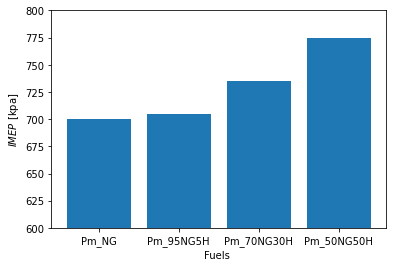

In [280]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
money = [(states.P).mean()/1.e3+200, (states3.P).mean()/1.e3+200, (states2.P).mean()/1.e3+200,(states1.P).mean()/1.e3+200]



fig, ax = plt.subplots()

plt.bar(x, money)
plt.xticks(x, ('Pm_NG', 'Pm_95NG5H', 'Pm_70NG30H', 'Pm_50NG50H'))
plt.ylabel('$IMEP$ [kpa]')

plt.xlabel('Fuels ')
plt.ylim(600, 800)

plt.show()



In [243]:
print('P_mean_NG:\t'+format((states.P).mean()/1.e3,'2.1f')+'kpa')
print('P_mean_50NG50H:\t'+format((states1.P).mean()/1.e3,'2.1f')+'kpa')
print('P_mean_70NG30H:\t'+format((states2.P).mean()/1.e3,'2.1f')+'kpa')
print('P_mean_95NG5H:\t'+format((states3.P).mean()/1.e3,'2.1f')+'kpa')


P_mean_NG:	500.3kpa
P_mean_50NG50H:	574.9kpa
P_mean_70NG30H:	534.8kpa
P_mean_95NG5H:	504.4kpa


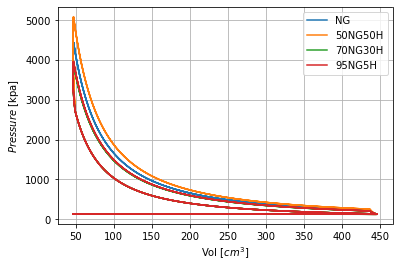

In [234]:
plt.clf()
plt.plot(V2[t > 0.04] * 10000000, states2.P[t > 0.04] / 1.e3, label='NG')
plt.plot(V1[t > 0.04] * 10000000, states1.P[t > 0.04] / 1.e3, label='50NG50H')
plt.plot(V[t > 0.04] * 10000000, states.P[t > 0.04] / 1.e3, label='70NG30H')
plt.plot(V3[t > 0.04] * 10000000, states3.P[t > 0.04] / 1.e3, label='95NG5H')
plt.legend(loc=0)
plt.grid(True)
plt.ylabel('$Pressure$ [kpa]')
plt.xlabel('Vol [$cm^3$]')
plt.savefig('ic_engine_multiple_gas.png')
plt.show()



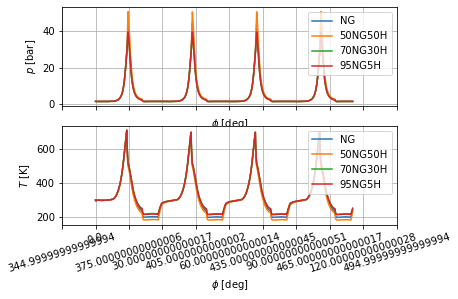

<Figure size 432x288 with 0 Axes>

In [235]:
plt.clf()
plt.subplot(211)
plt.plot(t, states2.P / 1.e5,label='NG')
plt.plot(t, states1.P / 1.e5,label='50NG50H')
plt.plot(t, states.P / 1.e5,label='70NG30H')
plt.plot(t, states3.P / 1.e5,label='95NG5H')
plt.legend(loc=0)
plt.grid(True)
plt.ylabel('$p$ [bar]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], [])
plt.subplot(212)
plt.plot(t, states2.T ,label='NG')
plt.plot(t, states1.T ,label='50NG50H')
plt.plot(t, states.T ,label='70NG30H')
plt.plot(t, states3.T ,label='95NG5H')
plt.legend(loc=0)
plt.grid(True)
plt.ylabel('$T$ [K]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], crank_angle(plt.xticks()[0]) * 180 / np.pi,
           rotation=17)
plt.show()
plt.savefig('ic_engine_t_p_T.png')
